# Quantum Gaussian Momenta

Retrieving momenta (mean and variance) of gaussian distribution embedded in amplitudes ```qml.AmplitudeEmbedding``` in PennyLane. The operators for the momenta are built from Pauli gates through ```qml.pauli_decompose```

See documentation https://docs.pennylane.ai/en/stable/

Notebook by: Óscar Amaro (2023)

In [143]:
import numpy as np
from numpy import sqrt, log, exp
import matplotlib.pyplot as plt
import pennylane as qml

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.23.5
pennylane==0.32.0


	 average variance
theory 0.2 0.09
numpy 0.19706667331318273 0.08753021521861419
Pennylane 0.1999487355481123 0.08991616387524605


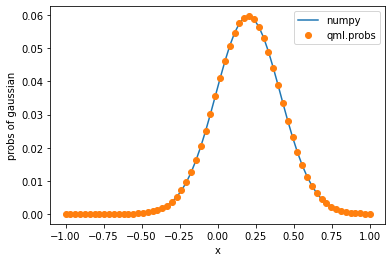

In [144]:
def quantumgaussian(mu=0, sigma=0.2, nqubits = 5, xmin = -1, xmax = 1):
    xlst = np.linspace(xmin,xmax,2**nqubits)
    ylst = exp(-0.5*(xlst-mu)**2/sigma**2)
    ylst = ylst/sqrt(np.sum(ylst**2))

    # operator for average x: requires nqubits local Z operators
    mat = np.zeros((2**nqubits,2**nqubits))
    for i in range(2**nqubits):
        mat[i,i] = xmin + i*(xmax-xmin)/(2**nqubits-1)
    op_avg = qml.pauli_decompose(mat)

    # operator for average x^2: requires ~2 nqubits (Z and ZZ) operators
    mat2 = np.zeros((2**nqubits,2**nqubits))
    for i in range(2**nqubits):
        mat2[i,i] = (xmin + i*(xmax-xmin)/(2**nqubits-1))**2
    op_var = qml.pauli_decompose(mat2)

    dev = qml.device('default.qubit', wires=nqubits)

    @qml.qnode(dev)
    def circuit(f=None):
        qml.AmplitudeEmbedding(features=f, wires=range(nqubits))
        return qml.expval(op_avg), qml.expval(op_var), qml.probs(wires=[i for i in range(nqubits)])

    print("\t average variance")
    print("theory", mu, sigma**2)
    avgNP = np.sum(ylst*xlst)/np.sum(ylst); varNP = np.sum(ylst*(xlst-avgNP)**2)/np.sum(ylst)
    print("numpy", avgNP, varNP )
    avg, var, probs = circuit(f=ylst)
    print("Pennylane", avg, 2*(var-avg**2) ) # why x2?

    plt.plot(xlst, ylst**2, label='numpy')
    plt.plot(xlst, probs, 'o', label=r'qml.probs')
    plt.xlabel(r'x')
    plt.ylabel(r'probs of gaussian')
    plt.legend()
    plt.show()

quantumgaussian(mu=0.2, sigma=0.3, nqubits=6)